In [ ]:
# Final Revision of Capstone Economic Indicator Combination

In [ ]:
# Economic Indicator Data Download Notes:
# File sequence # 2

# The purpose of this notebook is to download raw economic indicator data
# from online database sources

# Inputs:
# various downloaded economic indicator csv files

# Ouputs:
# single merged economic indicator csv file


In [ ]:
# mount google drive
from google.colab import drive
# this resets all file variables
drive.flush_and_unmount()
# mount/remount
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# import libraries:

# calculation
import pandas as pd
# file handling
import os
import glob
# helps with datafame manipulation
# (pd.merge/reduce instead of np.concat)
from functools import reduce
# scaling
from sklearn.preprocessing import MinMaxScaler
# plotting
import matplotlib.pyplot as plt


In [ ]:
# define various notebook objects

# Initialize shared direct
source_direct = r"/content/drive/MyDrive/Capstone_Docs_Shared"

# define filtered date range for final output dataframe
#(many of the economic KPIs begin in 1992)
beg_date = '1992-06-01'
# end date, short of present:
end_date = '2025-01-15'

# initialize list to store dataframes
df_list = []

# Initialize destination direct:
dest_direct = r"/content/drive/MyDrive/Capstone_Docs_Shared"

In [ ]:
# data load function:
def load_ei_data(filepath):
  df = pd.read_csv(f'{filepath}')
  return df


In [ ]:
# initialize list to store file paths
file_paths = []

# initialize list to store dataframes dLd from files
df_list = []

print("Input Files:")

# take source name file pattern:
pattern = os.path.join(source_direct, 'feature_*')

# use golb to populate file path list
file_paths = glob.glob(pattern)
#print(file_paths) $MC

# loop over file list
for i in file_paths:
  print(i)
  # load data from file
  df=load_ei_data(i)
  #print(df) $MC
  # append dataframe to list of dataframes:
  df_list.append(df)

# example file name format:
#'/content/drive/MyDrive/Capstone_Docs_Shared/feature_CPI_CPIAUCSL.csv'

Input Files:
/content/drive/MyDrive/Capstone_Docs_Shared/feature_cs_UMCSENT.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_dgo_DGORDER.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_gdp_GDP.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_ps_PCE.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_hsst_HOUST.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_rs_RSXFS.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_wiuc_ICSA.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_YC_T10Y2Y.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_PPI_PPIACO.csv
/content/drive/MyDrive/Capstone_Docs_Shared/feature_dgoxd_ADXDNO.csv


In [ ]:

# merge all dataframes on 'observation date' using outer join
# (use merge, reduce here instead of concat, bc concat doesnt merge dates right)
merged_ei_df = reduce(lambda left, right: pd.merge(left, right, on='observation_date', how='outer'), df_list)

print(merged_ei_df)

      observation_date  UMCSENT  DGORDER  GDP  PCE  HOUST  RSXFS      ICSA  \
0           1913-01-01      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
1           1913-02-01      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
2           1913-03-01      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
3           1913-04-01      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
4           1913-05-01      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
...                ...      ...      ...  ...  ...    ...    ...       ...   
16586       2025-03-08      NaN      NaN  NaN  NaN    NaN    NaN  220000.0   
16587       2025-03-10      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
16588       2025-03-11      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
16589       2025-03-12      NaN      NaN  NaN  NaN    NaN    NaN       NaN   
16590       2025-03-13      NaN      NaN  NaN  NaN    NaN    NaN       NaN   

       T10Y2Y  PPIACO  ADXDNO  
0         NaN    12.1     NaN  

In [ ]:
# data goes back very far, but there are a handful of missing days
# (days on which no observation fell)

# impute missing dates

# confirm that observation_date is in datetime format:
merged_ei_df['observation_date'] = pd.to_datetime(merged_ei_df['observation_date'])

# create complete daily date range
date_range = pd.date_range(start=merged_ei_df['observation_date'].min(), end=merged_ei_df['observation_date'].max(), freq='D')

# reindex with new dates AND reset index
merged_ei_df = merged_ei_df.set_index('observation_date').reindex(date_range).reset_index()

# rename new column back to observation_date
merged_ei_df = merged_ei_df.rename(columns={'index':'observation_date'})

# setting o_d as index allows quick slicing by date in next cell
merged_ei_df.set_index('observation_date', inplace=True)

In [ ]:
# imputing dates in last cell, plus sparse nature of data readings ...
# ... necessitates fill of nan values

# using forward fill is the best, because it only gives access to data AFTER...
# ... that indicator's real life reporting date ...
# ... IF you use linear imputation, that gives model access to clues...
# ... about future data reading before it is reported == LEAKAGE!!

# take a copy
process_ei_df = merged_ei_df.copy()

# count nans before ffill
print("NaN Values in Merged DF:")
print(process_ei_df.isna().sum())

# impute missing values with forwardfill
#merged_ei_df = merged_ei_df.fillna(method='ffill')
process_ei_df = process_ei_df.ffill()


# filter df by date next
filtered_df = process_ei_df.loc[beg_date:end_date]
filtered_df = filtered_df.reset_index()
print("NaN Values after Fill & Filter:")
print(filtered_df.isna().sum())
# (should be a minimal value)



NaN Values in Merged DF:
UMCSENT    40323
DGORDER    40584
GDP        40668
PCE        40187
HOUST      40187
RSXFS      40583
ICSA       37944
T10Y2Y     28788
PPIACO     39634
ADXDNO     40584
dtype: int64
NaN Values after Fill & Filter:
observation_date    0
UMCSENT             0
DGORDER             0
GDP                 0
PCE                 0
HOUST               0
RSXFS               0
ICSA                0
T10Y2Y              0
PPIACO              0
ADXDNO              0
dtype: int64


In [ ]:
# export unscaled data to csv

source_direct = r"/content/drive/MyDrive/Capstone_Docs_Shared"

file_name = r'unscaled_indicator_data.csv'

export_path = os.path.join(source_direct, file_name)

filtered_df.to_csv(export_path, index=False)


In [ ]:
# illustration of importance of unscaled vs scaled feature data

# (although we export the unscaled version, our ei data is ultimately scaled...
# ...in a proceeding NB)

# scale filtered df features:

scale_filt_df = filtered_df.copy()

# setting o_d as index allows quick feature name extraction
scale_filt_df.set_index('observation_date', inplace=True)

# select features to scale
features_to_scale = list(scale_filt_df.columns)

# scale features
# (on a 0 - 1 range, using MMS())
scaler = MinMaxScaler()
scale_filt_df[features_to_scale] = scaler.fit_transform(scale_filt_df[features_to_scale])

# reset index
scale_filt_df = scale_filt_df.reset_index()

# rename new column back to observation_date
scale_filt_df = scale_filt_df.rename(columns={'index':'observation_date'})



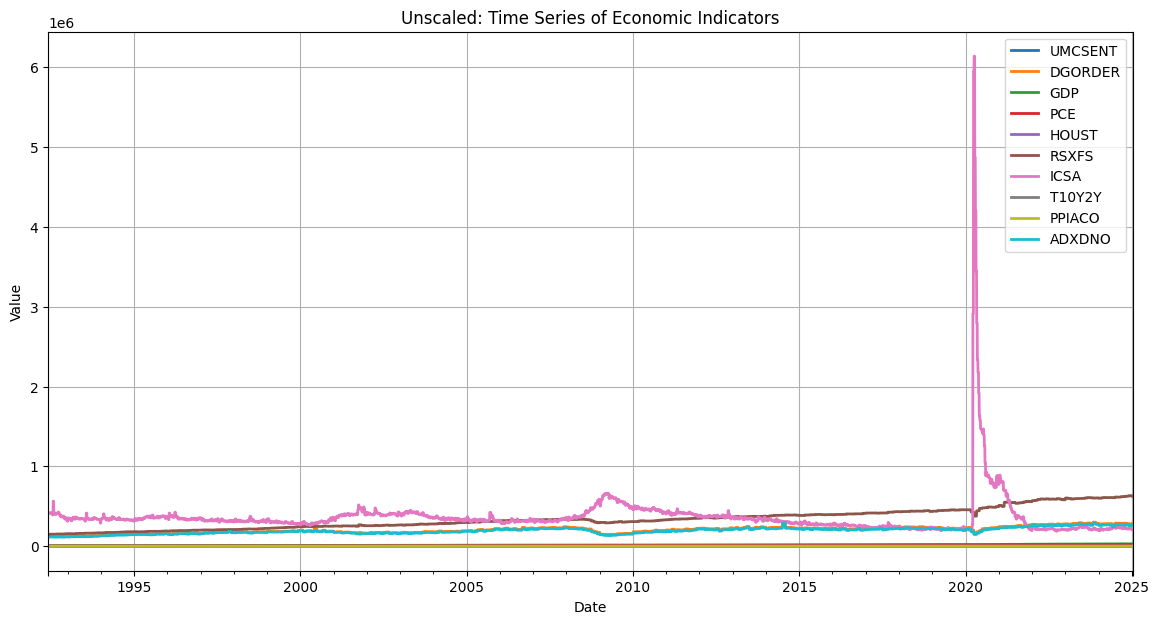

In [ ]:
# plot unscaled data --

# plotting

plot_df = filtered_df.copy()

# add o_d as index
# setting o_d as index allows quick feature name extraction
plot_df.set_index('observation_date', inplace=True)
plot_features = list(plot_df.columns)
plot_df[plot_features].plot(figsize=(14, 7), linewidth=2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Unscaled: Time Series of Economic Indicators')
plt.legend()
plt.grid(True)
plt.show()

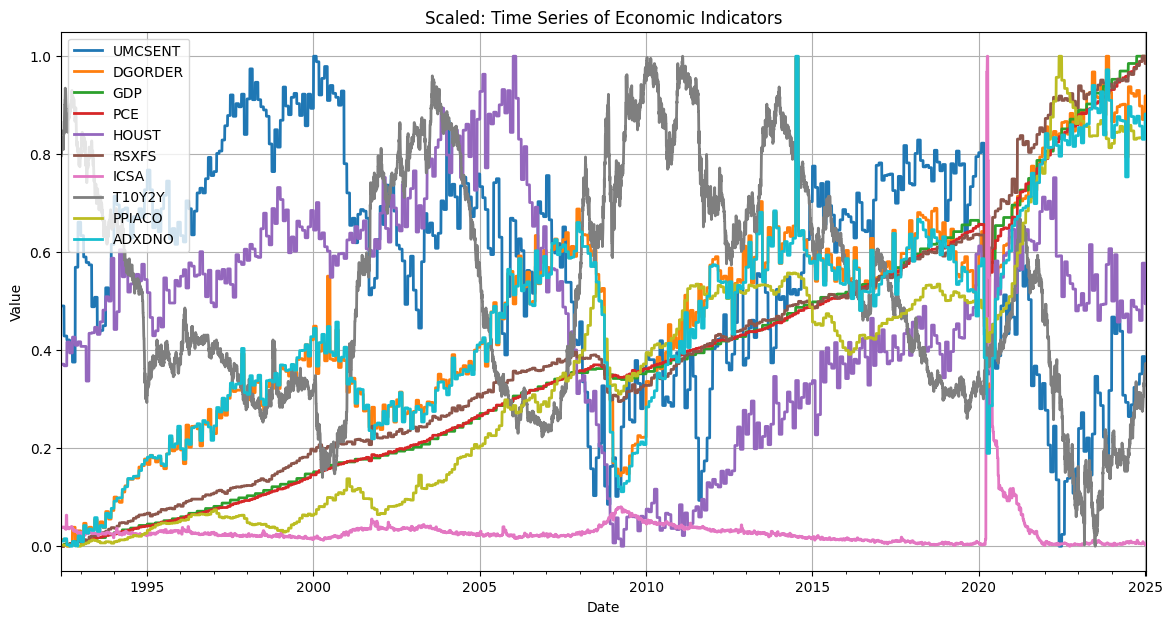

In [ ]:
# plot scaled data --

# plotting

plot_df_2 = scale_filt_df.copy()

# add o_d as index
# setting o_d as index allows quick feature name extraction
plot_df_2.set_index('observation_date', inplace=True)
plot_features = list(plot_df_2.columns)
plot_df_2[plot_features].plot(figsize=(14, 7), linewidth=2)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Scaled: Time Series of Economic Indicators')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# END OF FILE